# Network analysis in Senegal

### Objectives
    1)	Use measures of road-based accessibility to identify road segments that, if rehabilitated, would improve agricultural market activities in Senegal, including during flood conditions.
    2)	Gain a better understanding of the accessibility, connectivity, and criticality of roads in Senegal in relationship to agricultural origins, processing & transfer sites, and markets.

To this end, the team will develop an accessibility model which measures the travel time from sites of agricultural production to their nearest populated areas, processing centers, and markets. 

### Datasets for analysis
#### ORIGIN
    1) agriculture: MapSPAM 2017. Measuring value and potential value. Values might be reassigned to landcover extents (UMD 2019 30m).
    2) population: WorldPop 2020, UN-adjusted.
    3) settlement extent: GRID3 2020.
#### DESTINATION
    4) markets: derived from WorldPop 2020 and GRID3 2020 urban clusters.
    5) agricultural processing hubs: to be acquired.
#### TRAVEL ROUTE
    6) roads: OpenStreetMap, July 2021.
    7) elevation: 
#### OBSTACLE
    8) flood: FATHOM. 1-in-10, 20, and 50 year flood return periods. 
#### INTERVENTION
    9) upcoming road projects: AGEROUTE interventions separate from the World Bank-financed project
    10) targeted road projects: critical road segments identified by this accessibility model's baseline outputs


### Model design
#### Basic formula: 
    (a) Off-road driving time from origin to closest road node
    +
    (b) Driving time from road node in (a) to a destination (closeness measured by road segments speeds)

#### Model origin & destination (OD) sets:
    A)	Travel time from an area that has agricultural value/potential to the nearest processing hub (if provided).
    B)	Travel time from an area that has agricultural value/potential to the nearest larger settlement, (“larger” settlement identified using a case-appropriate population metric to be determined).
    C)	Travel time from an area that has agricultural value/potential to the nearest market.
    D)	Travel time from all settlements to the nearest market.
    E)	Travel time from larger settlements to the nearest market.

#### Before/after scenarios for each OD set:
    1)	Pre-project, baseline weather: No inclement weather. Road network status as of November 2021.
    2)	Pre-project, flood: 1-in-10, 1-in-20 and 1-in-50 year flood return period. Road network status as of November 2021.
    3)	Post-project, baseline weather: No inclement weather. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).
    4)	Post-project, flood: 1-in-10 year flood return period. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).

#### Notes:
    --Destinations are expected to be proximal to the road network, so no measure is taken between road and destination.
    --All travel times will be assigned to each model variation’s point of origin; the aggregation up to admin areas is possible if desired.
    --Obstacles & interventions modify the road segment speeds. Basic formula is then applied to the modified road network.


### Prep workspace

In [1]:
import os, sys
GISFolder = os.getcwd()
GISFolder

'C:\\Users\\wb527163\\GEO-Cdrive-Grace'

In [ ]:
# Note: needed to reinstall rtree due to geopandas import error. Did so in the console. 
# conda install -c conda-forge rtree=0.9.3

In [2]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
sys.path.append(r"C:\Users\wb527163\.conda\envs\geo\GOSTnets-master")
import GOSTnets as gn

In [3]:
import networkx as nx
import osmnx as ox
import numpy as np
import rasterio as rt
import shapely
from shapely.geometry import Point, box
from shapely.ops import unary_union
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point
import peartree

In [4]:
#### Might not use these
import fiona
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob

In [5]:
pth = os.path.join(GISFolder, "SEN-Cdrive") # Personal folder system for running model.
pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive'

In [6]:
out_pth = os.path.join(GISFolder, "SEN-Cdrive\outputs") # For storing intermediate outputs from the model.
out_pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive\\outputs'

In [7]:
team_pth = 'R:\\SEN\\GEO' # This is where the unmodified input data is stored. Finalized outputs also housed here.
team_pth

'R:\\SEN\\GEO'

### Prepare and clean the data

In [ ]:
# Notes:
# OSM road network is in WGS84. Projected each dataset to match.
# Starting as CSV (dataframe) and deriving geometry from there tends to avoid read errors.

#### Get centroids of polygonal origins and destinations.

In [8]:
# High density areas, the proxy for markets
HDurban = gpd.read_file("R:\SEN\GEO\Team\Projects\SEN_WPR_Urban\SEN_WPR_Urban.gdb", layer="SEN_urbanonly")
HDurban.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   mgrs_code        319 non-null    object  
 1   type             319 non-null    object  
 2   AREA_GEO         319 non-null    float64 
 3   SUM              318 non-null    float64 
 4   Total_DriveTime  312 non-null    float64 
 5   WP_dens          319 non-null    float64 
 6   urb              319 non-null    object  
 7   hd_urb           319 non-null    object  
 8   Urb_class        319 non-null    int64   
 9   Shape_Length     319 non-null    float64 
 10  Shape_Area       319 non-null    float64 
 11  geometry         319 non-null    geometry
dtypes: float64(6), geometry(1), int64(1), object(4)
memory usage: 30.0+ KB


In [ ]:
# Settlement areas. Probably won't use for this analysis.
# ssa_extents = gpd.read_file("R:\SEN\GEO\Settlement_Extents\GRID3_SEN_settlement_extents_20200625.gdb", layer="ssa_extents")
# ssa_extents.info()

In [9]:
# Hamlets are the most dispersed populated areas. Probably won't use for this analysis.
hamlet_extents = gpd.read_file("R:\SEN\GEO\Settlement_Extents\GRID3_SEN_settlement_extents_20200625.gdb", layer="hamlet_extents")
hamlet_extents.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125886 entries, 0 to 125885
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   mgrs_code     125886 non-null  object  
 1   type          125886 non-null  object  
 2   GlobalID      125886 non-null  object  
 3   Shape_Length  125886 non-null  float64 
 4   Shape_Area    125886 non-null  float64 
 5   geometry      125886 non-null  geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 5.8+ MB


In [10]:
# Reproject to projected CRS (UTM 28N) to allow for accurate centroid measure.
HDurban = HDurban.to_crs("EPSG:31028")
hamlet_extents = hamlet_extents.to_crs("EPSG:31028")
HDurban.crs

<Projected CRS: EPSG:31028>
Name: Yoff / UTM zone 28N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Senegal - onshore and offshore.
- bounds: (-20.22, 10.64, -11.36, 16.7)
Coordinate Operation:
- name: UTM zone 28N
- method: Transverse Mercator
Datum: Yoff
- Ellipsoid: Clarke 1880 (IGN)
- Prime Meridian: Greenwich

In [11]:
HDurban['centroid'] = HDurban['geometry'].centroid
hamlet_extents['centroid'] = hamlet_extents['geometry'].centroid
HDurban

,mgrs_code,type,AREA_GEO,SUM,Total_DriveTime,WP_dens,urb,hd_urb,Urb_class,Shape_Length,Shape_Area,geometry,centroid
0,28PCU1268_02,bua,6.825291,14992.022066,67.224775,2196.539770,1,0,1,0.430449,0.000567,"MULTIPOLYGON (((312071.758 1368674.156, 311975...",POINT (312092.146 1368185.846)
1,28PCU6189_01,bua,27.151434,186046.609754,0.000000,6852.183502,1,1,2,0.671746,0.002259,"MULTIPOLYGON (((362412.970 1386488.242, 362433...",POINT (361509.129 1388994.206)
2,28PCV6615_01,bua,12.946680,29013.022570,26.304661,2240.962297,1,0,1,0.349253,0.001078,"MULTIPOLYGON (((367111.839 1413763.221, 367043...",POINT (366381.356 1414948.377)
3,28PDV3804_01,bua,7.396509,31580.806516,90.292621,4269.691037,1,0,1,0.252963,0.000616,"MULTIPOLYGON (((438757.242 1402588.659, 438667...",POINT (438654.056 1404387.581)
4,28PHU0490_01,bua,12.646372,36115.813159,158.705391,2855.824066,1,0,1,0.399690,0.001052,"MULTIPOLYGON (((805974.419 1391192.747, 805877...",POINT (804773.084 1390402.163)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,28QED6022_03,ssa,2.086761,5401.902636,165.631981,2588.654416,1,0,1,0.098859,0.000177,"MULTIPOLYGON (((560218.829 1823649.417, 560225...",POINT (560476.544 1822733.460)
315,28QED9101_01,ssa,1.945801,5270.550862,194.971625,2708.679155,1,0,1,0.103579,0.000165,"MULTIPOLYGON (((591964.359 1802300.427, 591995...",POINT (591579.993 1801271.028)
316,28PCU8996_01,ssa,1.264396,5769.787077,30.357322,4563.274673,1,0,1,0.057864,0.000105,"MULTIPOLYGON (((389653.490 1396580.525, 389672...",POINT (389479.340 1396020.208)
317,28PCB9634_01,ssa,2.093282,5096.473311,13.650952,2434.680403,1,0,1,0.159170,0.000176,"MULTIPOLYGON (((396895.339 1634049.282, 396827...",POINT (395853.428 1634271.895)


In [12]:
hamlet_extents

,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,geometry,centroid
0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,"MULTIPOLYGON (((312628.929 1365556.418, 312624...",POINT (312643.659 1365626.539)
1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,"MULTIPOLYGON (((313250.671 1365704.850, 313277...",POINT (313188.766 1365540.193)
2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,"MULTIPOLYGON (((313476.964 1365931.550, 313477...",POINT (313473.832 1365869.571)
3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,"MULTIPOLYGON (((314918.465 1366356.355, 314916...",POINT (314845.335 1366381.262)
4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,"MULTIPOLYGON (((315137.148 1366435.601, 315133...",POINT (315118.245 1366514.411)
...,...,...,...,...,...,...,...
125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,"MULTIPOLYGON (((564064.948 1812494.457, 564061...",POINT (564125.180 1812551.470)
125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,"MULTIPOLYGON (((564160.192 1813891.072, 564164...",POINT (564159.267 1813827.524)
125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,"MULTIPOLYGON (((563763.297 1813785.773, 563816...",POINT (563851.024 1813674.633)
125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,"MULTIPOLYGON (((564217.554 1823899.891, 564214...",POINT (564260.335 1823947.187)


#### Prefer it in X,Y columns, so here we're extracting the coordinates from the centroid geometry column:

In [13]:
# 1. Treat the centroid column as a string
bua_extents["centroid"] = bua_extents["centroid"].astype('str')
ssa_extents["centroid"] = ssa_extents["centroid"].astype('str')
hamlet_extents["centroid"] = hamlet_extents["centroid"].astype('str')

bua_extents.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mgrs_code     215 non-null    object  
 1   type          215 non-null    object  
 2   GlobalID      215 non-null    object  
 3   Shape_Length  215 non-null    float64 
 4   Shape_Area    215 non-null    float64 
 5   geometry      215 non-null    geometry
 6   centroid      215 non-null    object  
dtypes: float64(2), geometry(1), object(4)
memory usage: 11.9+ KB


In [14]:
bua_extents.head()

,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,geometry,centroid
0,28PCU1268_02,bua,{F32712D7-2822-4CCE-9FE9-FF3E4DBFD431},0.430449,0.000567,"MULTIPOLYGON (((312071.758 1368674.156, 311975...",POINT (312092.146309 1368185.846213)
1,28PCU6189_01,bua,{5708B717-9FA7-4C2C-ACDC-917A18D6FB38},0.671746,0.002259,"MULTIPOLYGON (((362412.970 1386488.242, 362433...",POINT (361509.128567 1388994.206097)
2,28PCV6615_01,bua,{1E40CF8E-43F7-4005-B127-714455975853},0.349253,0.001078,"MULTIPOLYGON (((367111.839 1413763.221, 367043...",POINT (366381.355813 1414948.376699)
3,28PDV3804_01,bua,{21107C25-BC58-4B0D-99EA-4D3FA6616DEC},0.252963,0.000616,"MULTIPOLYGON (((438757.242 1402588.659, 438667...",POINT (438654.056109 1404387.580976)
4,28PFV1210_01,bua,{88766FE6-F6F9-41DD-805C-A050BC9D2915},0.068776,0.000127,"MULTIPOLYGON (((612460.230 1411669.103, 612472...",POINT (612399.74834 1410812.520655)


In [15]:
# 2. Strip the centroid column of extra characters
bua_extents["centroid"] = bua_extents["centroid"].str.strip('POINT ')
bua_extents["centroid"] = bua_extents["centroid"].str.strip('()')
ssa_extents["centroid"] = ssa_extents["centroid"].str.strip('POINT ')
ssa_extents["centroid"] = ssa_extents["centroid"].str.strip('()')
hamlet_extents["centroid"] = hamlet_extents["centroid"].str.strip('POINT ')
hamlet_extents["centroid"] = hamlet_extents["centroid"].str.strip('()')

# 3. Split the column into two based on the space between the coordinates.
XY_bua = bua_extents["centroid"].str.split(" ", expand=True)
bua_extents["X"] = XY_bua[0]
bua_extents["Y"] = XY_bua[1]

XY_ssa = ssa_extents["centroid"].str.split(" ", expand=True)
ssa_extents["X"] = XY_ssa[0]
ssa_extents["Y"] = XY_ssa[1]

XY_hamlet = hamlet_extents["centroid"].str.split(" ", expand=True)
hamlet_extents["X"] = XY_hamlet[0]
hamlet_extents["Y"] = XY_hamlet[1]

ssa_extents.head()

,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,geometry,centroid,X,Y
0,28PCU3968_03,ssa,{45BBCC18-F6E6-439A-A6B2-FEB423C79F6D},0.019743,0.000020,"MULTIPOLYGON (((339686.268 1368662.879, 339724...",339672.051357 1368380.6714,339672.051357,1368380.6714
1,28PCU4068_01,ssa,{40E8BC96-01D1-4E11-9B18-E686F2B1FD97},0.018078,0.000011,"MULTIPOLYGON (((339986.841 1369105.294, 340004...",340005.72358 1368838.888832,340005.72358,1368838.888832
2,28PCU3869_01,ssa,{5F723231-C8F5-43E2-A2F6-0CAF4691B3C3},0.092344,0.000095,"MULTIPOLYGON (((338362.128 1369774.788, 338449...",338235.508001 1369094.003039,338235.508001,1369094.003039
3,28PCU0970_02,ssa,{B21672A1-9B19-472F-98F7-CB10501A8C1B},0.034289,0.000030,"MULTIPOLYGON (((309801.524 1370501.826, 309784...",309199.850039 1370679.407458,309199.850039,1370679.407458
4,28PCU0871_02,ssa,{128A1E01-AB7C-4091-AAF3-C4DA0C3EFE45},0.026912,0.000027,"MULTIPOLYGON (((308214.230 1371952.885, 308266...",308175.263881 1371599.188917,308175.263881,1371599.188917


In [17]:
# We need to get rid of the old geometry variables as soon as possible to avoid any interference with georeferencing later on.
bua_extents = bua_extents.drop(columns=['geometry', 'centroid'])
ssa_extents = ssa_extents.drop(columns=['geometry', 'centroid'])
hamlet_extents = hamlet_extents.drop(columns=['geometry', 'centroid'])
ssa_extents.head()

,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,X,Y
0,28PCU3968_03,ssa,{45BBCC18-F6E6-439A-A6B2-FEB423C79F6D},0.019743,0.000020,339672.051357,1368380.6714
1,28PCU4068_01,ssa,{40E8BC96-01D1-4E11-9B18-E686F2B1FD97},0.018078,0.000011,340005.72358,1368838.888832
2,28PCU3869_01,ssa,{5F723231-C8F5-43E2-A2F6-0CAF4691B3C3},0.092344,0.000095,338235.508001,1369094.003039
3,28PCU0970_02,ssa,{B21672A1-9B19-472F-98F7-CB10501A8C1B},0.034289,0.000030,309199.850039,1370679.407458
4,28PCU0871_02,ssa,{128A1E01-AB7C-4091-AAF3-C4DA0C3EFE45},0.026912,0.000027,308175.263881,1371599.188917


In [18]:
# Geo file causes issues when using pandana_snap_c later on, so we're restarting with a dataframe.
# It's a bit roundabout, but the most reliable way is to create a fresh csv and re-read it in.
bua_extents.to_csv(os.path.join(out_pth, 'bua_pt.csv'))
bua_pt = os.path.join(out_pth, "bua_pt.csv")
bua_pt = pd.read_csv(bua_pt)
geometry = [Point(xy) for xy in zip(bua_pt.X, bua_pt.Y)]
crs = {'init': 'epsg:31028'} 
bua_pt = GeoDataFrame(bua_pt, crs=crs, geometry=geometry) 
bua_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/bua_pt.shp') 

# 215 observations.
bua_pt

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\wb527163\AppData\Local\Temp/ipykernel_1632/2218545480.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bua_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/bua_pt.shp')


,Unnamed: 0,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,X,Y,geometry
0,0,28PCU1268_02,bua,{F32712D7-2822-4CCE-9FE9-FF3E4DBFD431},0.430449,0.000567,312092.146309,1.368186e+06,POINT (312092.146 1368185.846)
1,1,28PCU6189_01,bua,{5708B717-9FA7-4C2C-ACDC-917A18D6FB38},0.671746,0.002259,361509.128567,1.388994e+06,POINT (361509.129 1388994.206)
2,2,28PCV6615_01,bua,{1E40CF8E-43F7-4005-B127-714455975853},0.349253,0.001078,366381.355813,1.414948e+06,POINT (366381.356 1414948.377)
3,3,28PDV3804_01,bua,{21107C25-BC58-4B0D-99EA-4D3FA6616DEC},0.252963,0.000616,438654.056109,1.404388e+06,POINT (438654.056 1404387.581)
4,4,28PFV1210_01,bua,{88766FE6-F6F9-41DD-805C-A050BC9D2915},0.068776,0.000127,612399.748340,1.410813e+06,POINT (612399.748 1410812.521)
...,...,...,...,...,...,...,...,...,...
210,210,28PCB3804_03,bua,{BCA72ACD-DE8C-45C1-ADC2-91D228BE5450},0.231759,0.000258,338685.366662,1.604621e+06,POINT (338685.367 1604621.213)
211,211,28PHA0099_01,bua,{F7BB8C89-F25A-4FDC-AB31-E6D8D8ADB6E3},0.191415,0.000295,800267.961991,1.599741e+06,POINT (800267.962 1599741.377)
212,212,28PCB8763_01,bua,{3E6032F4-BFE0-4EEB-B275-0C4B7C5E7FBF},0.242981,0.000795,387198.540850,1.663029e+06,POINT (387198.541 1663029.441)
213,213,28PCC6827_01,bua,{9163E21C-7976-4898-A7C7-D8C2D31BCB9E},0.494002,0.001754,368491.536717,1.727302e+06,POINT (368491.537 1727302.347)


In [19]:
ssa_extents.to_csv(os.path.join(out_pth, 'ssa_pt.csv'))
ssa_pt = os.path.join(out_pth, "ssa_pt.csv")
ssa_pt = pd.read_csv(ssa_pt)
geometry = [Point(xy) for xy in zip(ssa_pt.X, ssa_pt.Y)]
crs = {'init': 'epsg:31028'} 
ssa_pt = GeoDataFrame(ssa_pt, crs=crs, geometry=geometry) 
ssa_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/ssa_pt.shp') 

# 13,021 observations.
ssa_pt

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\wb527163\AppData\Local\Temp/ipykernel_1632/2455918336.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ssa_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/ssa_pt.shp')


,Unnamed: 0,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,X,Y,geometry
0,0,28PCU3968_03,ssa,{45BBCC18-F6E6-439A-A6B2-FEB423C79F6D},0.019743,0.000020,339672.051357,1.368381e+06,POINT (339672.051 1368380.671)
1,1,28PCU4068_01,ssa,{40E8BC96-01D1-4E11-9B18-E686F2B1FD97},0.018078,0.000011,340005.723580,1.368839e+06,POINT (340005.724 1368838.889)
2,2,28PCU3869_01,ssa,{5F723231-C8F5-43E2-A2F6-0CAF4691B3C3},0.092344,0.000095,338235.508001,1.369094e+06,POINT (338235.508 1369094.003)
3,3,28PCU0970_02,ssa,{B21672A1-9B19-472F-98F7-CB10501A8C1B},0.034289,0.000030,309199.850039,1.370679e+06,POINT (309199.850 1370679.407)
4,4,28PCU0871_02,ssa,{128A1E01-AB7C-4091-AAF3-C4DA0C3EFE45},0.026912,0.000027,308175.263881,1.371599e+06,POINT (308175.264 1371599.189)
...,...,...,...,...,...,...,...,...,...
13016,13016,28QCD9803_02,ssa,{64E30EAC-FAF9-4CDB-A5DA-3FAC80FDEE7F},0.018439,0.000014,398385.345259,1.803710e+06,POINT (398385.345 1803709.804)
13017,13017,28QDD8127_03,ssa,{C6B2EAFD-E796-4312-BE13-3D90E32C2F57},0.077607,0.000105,481448.380947,1.827184e+06,POINT (481448.381 1827183.761)
13018,13018,28QED6302_02,ssa,{35DBDB83-3AE3-418D-AE47-832CFCAF810A},0.012327,0.000007,563785.198525,1.802750e+06,POINT (563785.199 1802750.243)
13019,13019,28QED6418_04,ssa,{82A09CE9-692D-4903-842D-6FB8F85EEDC7},0.013314,0.000010,563974.059160,1.818300e+06,POINT (563974.059 1818299.503)


In [20]:
hamlet_extents.to_csv(os.path.join(out_pth, 'hamlet_pt.csv'))
hamlet_pt = os.path.join(out_pth, "hamlet_pt.csv")
hamlet_pt = pd.read_csv(hamlet_pt)
geometry = [Point(xy) for xy in zip(hamlet_pt.X, hamlet_pt.Y)]
crs = {'init': 'epsg:31028'} 
hamlet_pt = GeoDataFrame(hamlet_pt, crs=crs, geometry=geometry) 
hamlet_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/hamlet_pt.shp') 

# 125,886 observations.
hamlet_pt

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\wb527163\AppData\Local\Temp/ipykernel_1632/1526743604.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hamlet_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/hamlet_pt.shp')


,Unnamed: 0,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,X,Y,geometry
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,312643.659455,1.365627e+06,POINT (312643.659 1365626.539)
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,313188.766120,1.365540e+06,POINT (313188.766 1365540.193)
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,313473.831765,1.365870e+06,POINT (313473.832 1365869.571)
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,314845.335447,1.366381e+06,POINT (314845.335 1366381.262)
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,315118.244811,1.366514e+06,POINT (315118.245 1366514.411)
...,...,...,...,...,...,...,...,...,...
125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,564125.179572,1.812551e+06,POINT (564125.180 1812551.470)
125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,564159.267044,1.813828e+06,POINT (564159.267 1813827.524)
125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,563851.024190,1.813675e+06,POINT (563851.024 1813674.633)
125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,564260.334705,1.823947e+06,POINT (564260.335 1823947.187)


In [21]:
# The road graph will be in WGS84, so we'll start with that.
bua_pt = bua_pt.to_crs("EPSG:4326")
ssa_pt = ssa_pt.to_crs("EPSG:4326")
hamlet_pt = hamlet_pt.to_crs("EPSG:4326")

In [22]:
bua_pt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Unnamed: 0    215 non-null    int64   
 1   mgrs_code     215 non-null    object  
 2   type          215 non-null    object  
 3   GlobalID      215 non-null    object  
 4   Shape_Length  215 non-null    float64 
 5   Shape_Area    215 non-null    float64 
 6   X             215 non-null    float64 
 7   Y             215 non-null    float64 
 8   geometry      215 non-null    geometry
dtypes: float64(4), geometry(1), int64(1), object(3)
memory usage: 15.2+ KB


In [23]:
bua_pt.head()

,Unnamed: 0,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,X,Y,geometry
0,0,28PCU1268_02,bua,{F32712D7-2822-4CCE-9FE9-FF3E4DBFD431},0.430449,0.000567,312092.146309,1.368186e+06,POINT (-16.72670 12.37174)
1,1,28PCU6189_01,bua,{5708B717-9FA7-4C2C-ACDC-917A18D6FB38},0.671746,0.002259,361509.128567,1.388994e+06,POINT (-16.27319 12.56237)
2,2,28PCV6615_01,bua,{1E40CF8E-43F7-4005-B127-714455975853},0.349253,0.001078,366381.355813,1.414948e+06,POINT (-16.22947 12.79722)
3,3,28PDV3804_01,bua,{21107C25-BC58-4B0D-99EA-4D3FA6616DEC},0.252963,0.000616,438654.056109,1.404388e+06,POINT (-15.56341 12.70399)
4,4,28PFV1210_01,bua,{88766FE6-F6F9-41DD-805C-A050BC9D2915},0.068776,0.000127,612399.748340,1.410813e+06,POINT (-13.96292 12.76066)


In [11]:
# Earlier, created an approximate bounding area which includes parts of neighboring countries and all of The Gambia.
aoi = gpd.read_file("R:/SEN/GEO/Roads/bounding_senegam_buffered.shp") # AOI = Area of Interest
print(aoi)

   id       bound                                           geometry
0   0  senegambia  POLYGON ((-16.79591 16.13764, -16.44946 16.908...


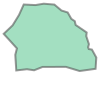

In [12]:
bound = aoi.geometry.iloc[0]
bound # Check that it's shaped like Senegal & Gambia.

In [13]:
# Check to confirm each file so far is the same coordinate system.
aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Get driving network from OSM.
Travel measured in length (meters).

In [20]:
networkType = 'drive'

In [21]:
gDrive = ox.graph_from_polygon(bound, network_type= 'drive')
# Note: length is measured in meters.
# Took approximately 30 min.

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [22]:
# Save all road nodes (points on the road) to file.
gDrive_node_gdf = gn.node_gdf_from_graph(gDrive)
gDrive_node_gdf.to_csv(os.path.join(out_pth, 'drive_dist_node.csv'))

In [24]:
?gn.convert_network_to_time

In [51]:
speed_dict = {
                'residential': 40,  # kmph
                'primary': 80, 
                'primary_link':60,
                'motorway':80,
                'motorway_link': 60,
                'trunk': 80,
                'trunk_link':60,
                'secondary': 70, 
                'secondary_link':50,
                'tertiary':60,
                'tertiary_link': 40,
                'unclassified':50, 
                'road':50,
                'crossing':40,
                'living_street':40,
                'construction':30,
                'footway':4.5,
                'path':4.5,
                'pedestrian':4.5
                }
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type = 'drive', speed_dict = speed_dict)
# Note: time is in seconds.

#### Save road nodes and road edges to file. Edges contains time measure

In [52]:
edges = gn.edge_gdf_from_graph(gTime)
nodes = gn.node_gdf_from_graph(gTime)

In [53]:
edges.info() # 1,111,798 edges

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1111798 entries, 0 to 1111797
Data columns (total 19 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   stnode    1111798 non-null  int64   
 1   endnode   1111798 non-null  int64   
 2   time      1111798 non-null  float64 
 3   mode      1111798 non-null  object  
 4   maxspeed  19114 non-null    object  
 5   area      8 non-null        object  
 6   lanes     61592 non-null    object  
 7   name      39209 non-null    object  
 8   bridge    1623 non-null     object  
 9   junction  1945 non-null     object  
 10  width     226 non-null      object  
 11  osmid     1111798 non-null  object  
 12  oneway    1111798 non-null  bool    
 13  tunnel    80 non-null       object  
 14  ref       26857 non-null    object  
 15  highway   1111798 non-null  object  
 16  length    1111798 non-null  float64 
 17  access    9343 non-null     object  
 18  geometry  1111798 non-null  geomet

In [54]:
nodes.info() # 368,843 nodes

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 368843 entries, 0 to 368842
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   node_ID       368843 non-null  int64   
 1   street_count  368843 non-null  int64   
 2   x             368843 non-null  float64 
 3   highway       192 non-null     object  
 4   ref           42 non-null      object  
 5   y             368843 non-null  float64 
 6   geometry      368843 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 22.5+ MB


In [55]:
edges.to_csv(os.path.join(out_pth, 'drive_time_edge.csv'))
nodes.to_csv(os.path.join(out_pth, 'drive_time_node.csv'))

In [56]:
# Save a pickle of the graph with the time measure for easy recall.
gn.save(gTime, 'SEN-Cdrive/outputs/gTime', '', edges = False, nodes = False)

### Origins and destinations

Measure distance from origin/destination to nearest node and save to file.

In [16]:
#%% If starting new session, reload graph from file
gTime = nx.read_gpickle("SEN-Cdrive/outputs/gTime.pickle")
bua_pt = gpd.read_file("SEN-Cdrive/outputs/bua_pt.shp")
ssa_pt = gpd.read_file("SEN-Cdrive/outputs/ssa_pt.shp")
hamlet_pt = gpd.read_file("SEN-Cdrive/outputs/hamlet_pt.shp")
bua_pt = bua_pt.to_crs("EPSG:4326")
ssa_pt = ssa_pt.to_crs("EPSG:4326")
hamlet_pt = hamlet_pt.to_crs("EPSG:4326")
ssa_pt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13021 entries, 0 to 13020
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed_ 0  13021 non-null  int64   
 1   mgrs_code   13021 non-null  object  
 2   type        13021 non-null  object  
 3   GlobalID    13021 non-null  object  
 4   Shape_Leng  13021 non-null  float64 
 5   Shape_Area  13021 non-null  float64 
 6   X           13021 non-null  float64 
 7   Y           13021 non-null  float64 
 8   geometry    13021 non-null  geometry
dtypes: float64(4), geometry(1), int64(1), object(3)
memory usage: 915.7+ KB


In [17]:
bua_pt.dtypes

Unnamed_ 0       int64
mgrs_code       object
type            object
GlobalID        object
Shape_Leng     float64
Shape_Area     float64
X              float64
Y              float64
geometry      geometry
dtype: object

In [169]:
?gn.pandana_snap_c

In [18]:
bua_snap = gn.pandana_snap_c(gTime, bua_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
bua_snap.to_csv('SEN-Cdrive/outputs/bua_snap.csv', index=True)
# Finished within a minute.
bua_snap.head()

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,X,Y,geometry,NN,NN_dist
0,0,28PCU1268_02,bua,{F32712D7-2822-4CCE-9FE9-FF3E4DBFD431},0.430449,0.000567,312092.146309,1.368186e+06,POINT (-16.72670 12.37174),2283044923,84.109763
1,1,28PCU6189_01,bua,{5708B717-9FA7-4C2C-ACDC-917A18D6FB38},0.671746,0.002259,361509.128567,1.388994e+06,POINT (-16.27319 12.56237),2119246531,39.014877
2,2,28PCV6615_01,bua,{1E40CF8E-43F7-4005-B127-714455975853},0.349253,0.001078,366381.355813,1.414948e+06,POINT (-16.22947 12.79722),1894405285,22.797121
3,3,28PDV3804_01,bua,{21107C25-BC58-4B0D-99EA-4D3FA6616DEC},0.252963,0.000616,438654.056109,1.404388e+06,POINT (-15.56341 12.70399),3355695913,42.169725
4,4,28PFV1210_01,bua,{88766FE6-F6F9-41DD-805C-A050BC9D2915},0.068776,0.000127,612399.748340,1.410813e+06,POINT (-13.96292 12.76066),7050097925,19.267328


In [19]:
ssa_snap = gn.pandana_snap_c(gTime, ssa_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
ssa_snap.to_csv('SEN-Cdrive/outputs/ssa_snap.csv', index=True)
ssa_snap.head()

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,X,Y,geometry,NN,NN_dist
0,0,28PCU3968_03,ssa,{45BBCC18-F6E6-439A-A6B2-FEB423C79F6D},0.019743,0.000020,339672.051357,1.368381e+06,POINT (-16.47310 12.37499),8602452847,3111.605086
1,1,28PCU4068_01,ssa,{40E8BC96-01D1-4E11-9B18-E686F2B1FD97},0.018078,0.000011,340005.723580,1.368839e+06,POINT (-16.47005 12.37915),8602452847,3658.684755
2,2,28PCU3869_01,ssa,{5F723231-C8F5-43E2-A2F6-0CAF4691B3C3},0.092344,0.000095,338235.508001,1.369094e+06,POINT (-16.48635 12.38137),8602452847,3666.198595
3,3,28PCU0970_02,ssa,{B21672A1-9B19-472F-98F7-CB10501A8C1B},0.034289,0.000030,309199.850039,1.370679e+06,POINT (-16.75344 12.39411),2282284668,1009.746966
4,4,28PCU0871_02,ssa,{128A1E01-AB7C-4091-AAF3-C4DA0C3EFE45},0.026912,0.000027,308175.263881,1.371599e+06,POINT (-16.76292 12.40236),2282284668,2267.462770


In [20]:
hamlet_snap = gn.pandana_snap_c(gTime, hamlet_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
hamlet_snap.to_csv('SEN-Cdrive/outputs/hamlet_snap.csv', index=True)
hamlet_snap.head()

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,X,Y,geometry,NN,NN_dist
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,312643.659455,1.365627e+06,POINT (-16.72147 12.34864),7761872879,396.520984
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,313188.766120,1.365540e+06,POINT (-16.71646 12.34789),7761872860,918.665696
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,313473.831765,1.365870e+06,POINT (-16.71386 12.35088),7761872847,952.759214
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,314845.335447,1.366381e+06,POINT (-16.70128 12.35559),7761872847,1923.779554
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,315118.244811,1.366514e+06,POINT (-16.69877 12.35680),7761872847,2181.254122


### Create travel time values for the road nodes nearest to each service.

Using calculate_OD.

In [17]:
# If starting a new session, load from file.
bua_snap = os.path.join(out_pth, "bua_snap.csv")
bua_snap = pd.read_csv(bua_snap)
ssa_snap = os.path.join(out_pth, "ssa_snap.csv")
ssa_snap = pd.read_csv(ssa_snap)
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)
gTime = nx.read_gpickle("SEN-Cdrive/outputs/gTime.pickle")

In [21]:
# We only need to find the origin-destination pairs for nodes closest to the origins and services,
# and some nodes will be the nearest for more than one service (and definitely for multiple origins).
origins = list(hamlet_snap.NN.unique())

In [22]:
list_bua = list(bua_snap.NN.unique()) 
list_ssa = list(ssa_snap.NN.unique()) 
# If more than one set of destinations, you can combine the sets to go into a single OD matrix using this code:
destslist = list_bua + list_ssa
dests = list(set(destslist))

In [23]:
len(origins) # 23108 unique nearest nodes (average of 5 origins per node).

23108

In [24]:
len(dests) # 8619 unique nearest nodes.

8619

In [25]:
fail_value = 999999999 # If there is no shortest path, the OD pair will be assigned the fail value.

In [26]:
gn.example_edge(gTime)

(358284990, 5329792501, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 73.22200000000001, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000246BDE54DF0>, 'time': 5.271984000000001, 'mode': 'drive'})


In [27]:
OD = gn.calculate_OD(gTime, origins, dests, fail_value, weight = 'time')
# This took several hours.

In [28]:
OD_df = pd.DataFrame(OD, index = origins, columns = dests)

In [29]:
OD_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23108 entries, 7761872879 to 4072041221
Columns: 8619 entries, 3496771586 to 8555593727
dtypes: float64(8619)
memory usage: 1.5 GB


In [30]:
OD_df.tail()

,3496771586,8555593732,4459200517,4229464070,4505272327,4505272330,4505272345,4229464092,3177807901,7870644257,...,8555593693,8555593694,5703270365,4236902368,4236902371,7967145957,5703270384,3306192886,4551507963,8555593727
8449983186,24196.954837,20484.469686,28386.390073,21877.466257,15803.788090,15799.776475,15827.431882,21821.459203,24176.266474,10241.144856,...,20623.112526,20582.854302,10045.618245,20416.393462,20484.885262,14072.062252,10040.032935,18559.584430,16072.483550,20547.976134
4072935008,24524.572813,20812.087662,28714.008049,22205.084233,16131.406066,16127.394451,16155.049858,22149.077179,24503.884450,10705.227137,...,20950.730502,20910.472278,10373.236221,20744.011438,20812.503238,14399.680228,10367.650911,17684.151352,16400.101526,20875.594110
4072935012,24558.608683,20846.123532,28748.043919,22239.120103,16165.441936,16161.430321,16189.085728,22183.113049,24537.920320,10739.263007,...,20984.766372,20944.508148,10407.272091,20778.047308,20846.539108,14433.716098,10401.686781,17683.342582,16434.137396,20909.629980
8558304561,25581.992953,21869.507802,29771.428189,23262.504373,17188.826206,17184.814591,17212.469998,23206.497319,25561.304590,11762.647277,...,22008.150642,21967.892418,11430.656361,21801.431578,21869.923378,15457.100368,11425.071051,18099.865153,17457.521666,21933.014250
4072041221,24595.564765,20883.079614,28785.000001,22276.076185,16202.398018,16198.386403,16226.041810,22220.069131,24574.876402,10639.754784,...,21021.722454,20981.464230,10444.228173,20815.003390,20883.495190,14470.672180,10438.642863,18702.806554,16471.093478,20946.586062


In [31]:
# Convert to minutes and save to file.
OD_min = OD_df[OD_df <fail_value] / 60
OD_min.to_csv(os.path.join(out_pth, 'OD.csv'))

In [32]:
OD_min.tail(20)

,3496771586,8555593732,4459200517,4229464070,4505272327,4505272330,4505272345,4229464092,3177807901,7870644257,...,8555593693,8555593694,5703270365,4236902368,4236902371,7967145957,5703270384,3306192886,4551507963,8555593727
8073203019,304.659681,271.873603,374.483601,236.691541,135.463572,135.396712,135.857635,235.758090,304.314875,64.112149,...,271.639602,270.968632,87.202267,212.340328,213.481858,106.601475,87.109179,344.185971,179.687681,272.932044
8071408643,300.711880,267.925802,370.535800,232.743740,131.515771,131.448911,131.909834,231.810290,300.367074,69.465920,...,267.691801,267.020831,87.231682,208.392527,209.534057,102.653674,87.138594,344.215386,179.717096,268.984243
3717192287,269.724743,236.938665,339.548663,231.066600,129.838630,129.771770,130.232693,230.133149,269.379936,100.112989,...,236.704664,236.033694,41.831474,206.715386,207.856916,100.976533,41.738386,298.815178,134.316888,237.997106
4186362309,216.615231,306.697138,195.628989,378.748735,422.771961,422.705101,423.166024,377.556208,292.437507,461.575466,...,306.463137,305.792167,375.392314,424.256557,425.398087,415.729922,375.299225,107.139880,393.493928,307.755579
7805596740,343.651752,310.865674,413.475672,275.683613,174.455643,174.388783,174.849706,274.750162,343.306946,66.800369,...,310.631674,309.960703,141.057712,251.332399,252.473929,146.895546,140.964624,380.795962,233.543126,311.924115
4071912759,337.190380,278.544794,407.014301,289.038918,187.810949,187.744088,188.205012,288.105467,336.845574,89.479452,...,280.855508,280.184538,101.334770,264.687705,265.829235,160.250851,101.241682,296.611056,201.782525,279.603235
6021242885,336.929442,278.283856,406.753362,289.299857,188.071887,188.005027,188.465950,288.366406,336.584636,89.740390,...,280.594570,279.923599,101.073832,264.948643,266.090173,160.511790,100.980743,296.350117,201.521587,279.342296
6026792324,333.119957,274.474371,402.943878,294.461814,193.233845,193.166985,193.627908,293.528363,332.775151,95.552026,...,276.785085,276.114115,97.264348,270.110601,271.252131,164.371748,97.171259,292.540633,197.712103,275.532812
2281084786,330.651449,272.005863,400.475369,291.993306,190.765336,190.698476,191.159399,291.059855,330.306643,96.924695,...,274.316577,273.645606,94.795839,267.642092,268.783622,161.903239,94.702750,290.072124,195.243594,273.064303
9206374054,294.073356,209.066171,363.897277,320.905211,219.677242,219.610382,220.071305,319.971761,293.728550,221.774212,...,211.376885,210.705914,135.591060,296.553998,297.695528,190.815145,135.497971,225.671812,208.449413,210.124611


In [35]:
# If more than one destination, create POI-specific ODs and save to file.
OD_bua = OD_df.loc[:, list_bua]
OD_bua = OD_bua[OD_bua < fail_value] / 60 
OD_bua.to_csv(os.path.join(out_pth, 'OD_bua.csv'))
OD_bua.tail()

,2283044923,2119246531,1894405285,3355695913,7050097925,8597133978,5082638962,3490825773,8636590476,4226629642,...,3754770169,3418418812,2514015906,1909086666,3670550355,2961067223,2548216982,3717191831,1983641803,4603303806
8449983186,488.847199,433.607729,408.413059,391.837899,511.097794,591.432793,579.992596,458.440851,353.059804,338.552897,...,361.847081,417.970770,205.310073,200.646103,203.130314,215.419536,433.593299,135.785165,80.884663,339.709292
4072935008,494.307499,439.068029,413.873359,397.298199,516.558094,596.893093,585.452895,463.901150,358.520104,344.013196,...,367.307380,423.431070,213.044778,208.380807,210.865019,223.154240,419.002748,141.245464,86.344963,325.118741
4072935012,494.874763,439.635293,414.440623,397.865463,517.125359,597.460357,586.020160,464.468415,359.087368,344.580461,...,367.874645,423.998334,213.612042,208.948072,211.432284,223.721505,418.989269,141.812729,86.912227,325.105262
8558304561,511.931168,456.691698,431.497028,414.921868,534.181763,614.516762,603.076564,481.524819,376.143773,361.636865,...,384.931049,441.054739,230.668447,226.004476,228.488688,240.777909,425.931311,158.869133,103.968632,332.047304
4072041221,495.490698,440.251228,415.056558,398.481398,517.741293,598.076292,586.636094,465.084349,359.703303,345.196396,...,368.490580,424.614269,211.953572,207.289602,209.773813,222.063034,435.980335,142.428664,87.528162,342.096328


In [36]:
OD_ssa = OD_df.loc[:, list_ssa]
OD_ssa = OD_ssa[OD_ssa < fail_value] / 60 
OD_ssa.to_csv(os.path.join(out_pth, 'OD_ssa.csv'))
OD_ssa.tail()

,8602452847,2282284668,3319267662,2855717267,2629110597,2688809396,3789990578,3794859116,6164016987,2142496597,...,4076308493,9210412531,1504562865,8443693157,8449983204,8449983165,1990545723,9207632325,8449983219,8450698140
8449983186,489.779974,490.489051,465.537213,480.560054,464.791602,490.642296,499.221759,456.339120,477.504670,469.352061,...,19.620164,50.206813,45.711652,41.943814,0.761651,6.153029,245.093432,242.891155,5.352469,32.293983
4072935008,495.240274,495.949351,470.997512,486.020353,470.251902,496.102596,504.682058,461.799419,482.964969,474.812360,...,50.379873,99.103488,94.608327,90.840488,62.238097,62.864937,230.502881,228.300604,66.828915,73.424882
4072935012,495.807538,496.516615,471.564777,486.587618,470.819166,496.669860,505.249323,462.366684,483.532234,475.379625,...,50.947137,99.670753,95.175591,91.407753,62.805361,63.432201,230.489402,228.287124,67.396180,73.411403
8558304561,512.863943,513.573020,488.621181,503.644022,487.875571,513.726265,522.305727,479.423088,500.588638,492.436029,...,68.003542,115.061959,110.566797,108.464157,79.861766,80.488606,237.431444,235.229167,84.452584,82.314649
4072041221,496.423473,497.132550,472.180711,487.203553,471.435101,497.285795,505.865258,462.982619,484.148169,475.995559,...,26.263663,54.767946,50.272785,46.504946,7.405150,8.540064,247.480468,245.278191,7.724495,34.681019


### Filter 1st nearest

#### Check each file to make sure nearest neighbor column is named correctly. If not, rename.

In [ ]:
# Reload from file even if already loaded. Quickest way to ensure NN is a column rather than only the index.
OD = os.path.join(out_pth, "OD.csv")
OD = pd.read_csv(OD)

In [37]:
# If more than one destination set, reload those instead of full OD file.
OD_bua = os.path.join(out_pth, "OD_bua.csv")
OD_bua = pd.read_csv(OD_bua)
OD_ssa = os.path.join(out_pth, "OD_ssa.csv")
OD_ssa = pd.read_csv(OD_ssa)

In [40]:
OD_ssa.tail(10)

,NN,8602452847,2282284668,3319267662,2855717267,2629110597,2688809396,3789990578,3794859116,6164016987,...,4076308493,9210412531,1504562865,8443693157,8449983204,8449983165,1990545723,9207632325,8449983219,8450698140
23098,4603303859,553.776589,567.228010,542.276172,557.299013,541.530561,567.381255,575.960718,533.078079,554.243629,...,355.117554,348.489907,343.994745,345.506304,339.500276,334.108898,95.179562,99.255301,336.226402,315.742597
23099,8382671047,555.600728,556.309805,531.357966,546.380807,530.612356,556.463050,565.042512,522.159873,543.325423,...,304.628251,298.000604,293.505442,295.017001,289.010973,283.619595,44.690259,48.765998,285.737099,265.253294
23100,8382671039,555.514274,556.223351,531.271513,546.294354,530.525902,556.376596,564.956059,522.073420,543.238970,...,304.541797,297.914151,293.418989,294.930548,288.924520,283.533142,44.603805,48.679544,285.650645,265.166840
23101,8463478851,469.969785,470.678862,445.727023,460.749864,444.981413,470.832107,479.411569,436.528930,457.694480,...,14.183212,62.906827,58.411665,54.643827,26.041435,26.668276,265.608679,263.406402,30.632254,52.809230
23102,8452098512,484.708353,485.417430,460.465592,475.488433,459.719981,485.570675,494.150138,451.267499,472.433049,...,6.297828,58.303162,53.808000,50.040162,17.138240,17.765080,256.705484,254.503207,21.729058,43.906035
23103,8449983186,489.779974,490.489051,465.537213,480.560054,464.791602,490.642296,499.221759,456.339120,477.504670,...,19.620164,50.206813,45.711652,41.943814,0.761651,6.153029,245.093432,242.891155,5.352469,32.293983
23104,4072935008,495.240274,495.949351,470.997512,486.020353,470.251902,496.102596,504.682058,461.799419,482.964969,...,50.379873,99.103488,94.608327,90.840488,62.238097,62.864937,230.502881,228.300604,66.828915,73.424882
23105,4072935012,495.807538,496.516615,471.564777,486.587618,470.819166,496.669860,505.249323,462.366684,483.532234,...,50.947137,99.670753,95.175591,91.407753,62.805361,63.432201,230.489402,228.287124,67.396180,73.411403
23106,8558304561,512.863943,513.573020,488.621181,503.644022,487.875571,513.726265,522.305727,479.423088,500.588638,...,68.003542,115.061959,110.566797,108.464157,79.861766,80.488606,237.431444,235.229167,84.452584,82.314649
23107,4072041221,496.423473,497.132550,472.180711,487.203553,471.435101,497.285795,505.865258,462.982619,484.148169,...,26.263663,54.767946,50.272785,46.504946,7.405150,8.540064,247.480468,245.278191,7.724495,34.681019


In [39]:
OD_bua.rename(columns={'Unnamed: 0': 'NN'}, inplace=True)
OD_ssa.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) # Repeat for each OD set, if needed.

#### Find first, second, and third nearest destination for each origin node. 

In [41]:
fail_value = 999999999

In [42]:
# Nearest
OD_bua["bua1"] = 0
sub = OD_bua.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_bua["bua1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
bua1 = OD_bua[['NN', 'bua1']] # Remove unnecessary OD values.
bua1.to_csv(os.path.join(out_pth, 'fromhamlet_drive/bua1.csv'))


# Second nearest
dupes = OD_bua.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_bua.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.

OD_bua["bua2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_bua["bua2"] = Dsub.min(axis=1) 
bua2 = OD_bua.loc[:,['NN', 'bua2']] 
bua2.to_csv(os.path.join(out_pth, 'fromhamlet_drive/bua2.csv'))


# Third nearest
dupes = OD_bua.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_bua.where(~dupes, fail_value)
 
OD_bua["bua3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_bua["bua3"] = Dsub.min(axis=1)
bua3 = OD_bua.loc[:,['NN', 'bua3']]
bua3.to_csv(os.path.join(out_pth, 'fromhamlet_drive/bua3.csv'))


# Combine and write to file
bua_all = OD_bua.loc[:,['NN', 'bua1', 'bua2', 'bua3']]
bua_all.to_csv(os.path.join(out_pth, 'fromhamlet_drive/bua_all.csv'))
bua_all.head()

,NN,bua1,bua2,bua3
0,7761872879,3.601602,62.713982,84.233782
1,7761872860,2.879157,61.991537,83.511337
2,7761872847,1.830102,60.942482,82.462282
3,8604836683,69.841801,92.811330,127.855787
4,8604829828,75.434624,98.404153,133.448610


In [43]:
# Nearest
OD_ssa["ssa1"] = 0
sub = OD_ssa.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_ssa["ssa1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
ssa1 = OD_ssa[['NN', 'ssa1']] # Remove unnecessary OD values.
ssa1.to_csv(os.path.join(out_pth, 'fromhamlet_drive/ssa1.csv'))


# Second nearest
dupes = OD_ssa.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_ssa.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.

OD_ssa["ssa2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_ssa["ssa2"] = Dsub.min(axis=1) 
ssa2 = OD_ssa.loc[:,['NN', 'ssa2']] 
ssa2.to_csv(os.path.join(out_pth, 'fromhamlet_drive/ssa2.csv'))


# Third nearest
dupes = OD_ssa.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_ssa.where(~dupes, fail_value)
 
OD_ssa["ssa3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_ssa["ssa3"] = Dsub.min(axis=1)
ssa3 = OD_ssa.loc[:,['NN', 'ssa3']]
ssa3.to_csv(os.path.join(out_pth, 'fromhamlet_drive/ssa3.csv'))
ssa3.head()


# Combine and write to file
ssa_all = OD_ssa.loc[:,['NN', 'ssa1', 'ssa2', 'ssa3']]
ssa_all.to_csv(os.path.join(out_pth, 'fromhamlet_drive/ssa_all.csv'))
ssa_all.head()

,NN,ssa1,ssa2,ssa3
0,7761872879,6.780075,6.933320,15.512783
1,7761872860,6.057630,6.210875,14.790338
2,7761872847,5.008575,5.161820,13.741283
3,8604836683,23.744689,57.646103,59.729140
4,8604829828,29.337512,63.238926,65.321963
